In [0]:
import os

os.getcwd()
data_resources_path = os.path.join("resources", "data").replace("\\","/")
if (not os.path.exists(data_resources_path)):
    os.makedirs(data_resources_path)



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Download the datasets
# Download Training Dataset
!wget --quiet -O ./resources/data/train_data_keras.tar.gz https://cocl.us/DL0320EN_TRAIN_TAR_KERAS
!tar -xzf resources/data/train_data_keras.tar.gz -C resources/data --exclude '.*'

# # Download Validation Dataset
!wget --quiet -O ./resources/data/validation_data_keras.tar.gz https://cocl.us/DL0320EN_VALID_TAR_KERAS
!tar -xzf resources/data/validation_data_keras.tar.gz -C resources/data --exclude '.*'

In [0]:
#Import Keras Modules
import keras 
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model

#Import Non-Keras Modules
#from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

In [0]:
#Load Image Dataset 
train_data_dir = './resources/data/train_data_keras'
validation_data_dir = './resources/data/validation_data_keras'
classes = ['5', '10', '20', '50', '100', '200', '500']

In [0]:
#Create the ImageDataGenerator objects
BATCH_SIZE=10
TARGET_SIZE = (224, 224)
SEED = 0

train_generator = ImageDataGenerator().flow_from_directory(train_data_dir,
                                                            target_size=TARGET_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            classes=classes,
                                                            seed=0,
                                                            shuffle=True)
validation_generator = ImageDataGenerator().flow_from_directory(validation_data_dir,
                                                                target_size=TARGET_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                classes=classes,
                                                                shuffle=True)

Found 70 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [0]:
#Question 1: prepation
#Step1:  Load the pre-trained model ResNet50. Set weights='imagenet'
resnet_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 8s 0us/step


In [0]:
#Step2:Set all the model's layers parameter Trainable=False
for layer in resnet_model.layers:
    layer.trainable = False

In [0]:
#Step3: Build a customized model to classify the seven different categories instead of the 1000 images the resnet model has been trained on
feature_extrator_layer = resnet_model.layers[-2].output
joint_model = Dense(len(classes), activation='softmax')(feature_extrator_layer)

#take model's input layer
model_input_layer = resnet_model.input

#Put together these two parts
model_resnet = Model(inputs=model_input_layer, outputs=joint_model)

#compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
N_EPOCHS = 4
STEPS = train_generator.n // train_generator.batch_size
model_resnet.fit_generator(generator=train_generator, validation_data=validation_generator, steps_per_epoch=STEPS, epochs=N_EPOCHS)

Epoch 1/4
7/7 [==============================] - 30s 4s/step - loss: 2.0544 - accuracy: 0.1714 - val_loss: 2.6913 - val_accuracy: 0.2143
Epoch 2/4
7/7 [==============================] - 27s 4s/step - loss: 1.1486 - accuracy: 0.7143 - val_loss: 1.7678 - val_accuracy: 0.2714
Epoch 3/4
7/7 [==============================] - 27s 4s/step - loss: 0.5329 - accuracy: 0.9857 - val_loss: 1.0389 - val_accuracy: 0.3571
Epoch 4/4
7/7 [==============================] - 27s 4s/step - loss: 0.2681 - accuracy: 1.0000 - val_loss: 1.1853 - val_accuracy: 0.4286


In [0]:
import plotly.express as px
import plotly.graph_objects as go

history = model_resnet.history
history.history
hor_ax = np.arange(0, N_EPOCHS, 1)

fig = go.Figure(data=go.Scatter(x=hor_ax, y=history.history['loss']))
fig.update_layout(title={'text':'Average Loss vs Epochs', 'x':0.5},
                  xaxis_title='EPOCHS',
                  yaxis_title='Average Loss Per Epoch')
fig.show()
fig1 = go.Figure(data=go.Scatter(x=hor_ax, y=history.history['accuracy']))
fig1.update_layout(title={'text':'Accuracy vs Epochs', 'x':0.5},
                  xaxis_title='EPOCHS',
                  yaxis_title='Accuracy')
fig1.show()

In [0]:
#Question 3.3: Plot 5 random images with their predictions
test_valid_generator = ImageDataGenerator().flow_from_directory(validation_data_dir,
                                                                target_size=(224,224),
                                                                batch_size=BATCH_SIZE,
                                                                classes=classes,
                                                                seed=0,
                                                                shuffle=False)


Found 70 images belonging to 7 classes.


In [0]:
#Make predictions on the validation dataset
predictions = model_resnet.predict_generator(test_valid_generator)

In [0]:
#Get the positions with the highest values for every prediction
max_values = np.argmax(predictions, axis=1)

array([6, 6, 4, 4, 6, 6, 6, 6, 4, 4, 1, 6, 4, 1, 1, 6, 1, 1, 1, 1, 6, 6,
       6, 6, 6, 6, 2, 4, 6, 6, 3, 6, 3, 3, 6, 6, 6, 6, 4, 4, 4, 6, 4, 6,
       6, 4, 6, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 1, 6, 6,
       6, 6, 1, 6])

In [0]:
#Get the class indices, reverse it to make matching predictions with class indices
class_indices = test_valid_generator.class_indices
class_indices_reversed = {v: k for k,v in class_indices.items() }
predictions_labels = np.vectorize(class_indices_reversed.get)(max_values)

In [0]:
#Get the true label by analyzing the folder name on the image resource path
true_labels = [x.split('/')[0] for x in test_valid_generator.filenames]

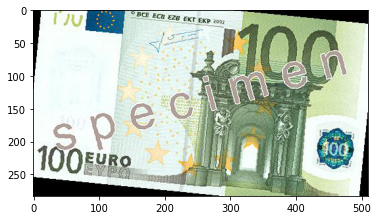

Predicted Label 100
True Label 100
Correctly classified


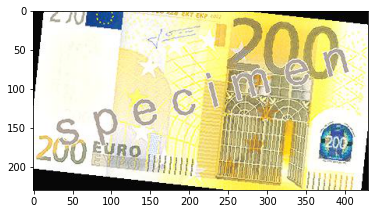

Predicted Label 100
True Label 200
Misclassified


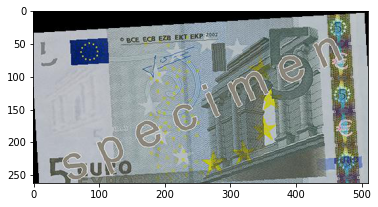

Predicted Label 500
True Label 5
Misclassified


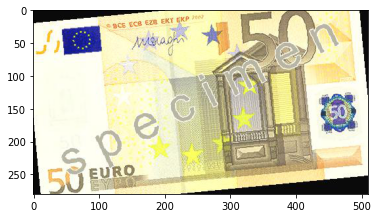

Predicted Label 50
True Label 50
Correctly classified


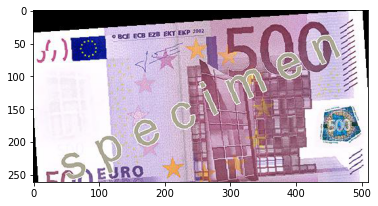

Predicted Label 500
True Label 500
Correctly classified


In [0]:
#Plot five random images and their predictions
random.seed(0)
numbers = [random.randint(0, 69) for i in range(0, 5)]

for number in numbers:
  plt.figure()
  img = Image.open(test_valid_generator.filepaths[number])
  imshow(img)
  plt.show()
  predicted_l = predictions_labels[number]
  true_l = true_labels[number]
  print('Predicted Label {}'.format(predicted_l))
  print('True Label {}'.format(true_l))
  if (predicted_l != true_l):
    print('Misclassified')
  else:
    print('Correctly classified')
  

In [0]:
#Repeat the steps above using the VGG16 model.
vgg_model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 34s 0us/step


In [94]:
for layer in vgg_model.layers:
  layer.trainable = False

#Step3: Build a customized model to classify the seven different categories instead of the 1000 images the resnet model has been trained on
feature_extrator_layer = vgg_model.layers[-2].output
joint_model = Dense(len(classes), activation='softmax')(feature_extrator_layer)

#take model's input layer
model_input_layer = vgg_model.input

#Put together these two parts
model_vgg = Model(inputs=model_input_layer, outputs=joint_model)

#compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.fit_generator(generator=train_generator, validation_data=validation_generator, steps_per_epoch=STEPS, epochs=N_EPOCHS)

Epoch 1/4
7/7 [==============================] - 72s 10s/step - loss: 2.1470 - accuracy: 0.3857 - val_loss: 0.8681 - val_accuracy: 0.6286
Epoch 2/4
7/7 [==============================] - 71s 10s/step - loss: 0.2834 - accuracy: 0.9143 - val_loss: 0.1987 - val_accuracy: 0.9286
Epoch 3/4
7/7 [==============================] - 72s 10s/step - loss: 0.0530 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9714
Epoch 4/4
7/7 [==============================] - 75s 11s/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9714


In [0]:
history = model_vgg.history

fig = go.Figure(data=go.Scatter(x=hor_ax, y=history.history['loss']))
fig.update_layout(title={'text':'Average Loss vs Epochs', 'x':0.5},
                  xaxis_title='EPOCHS',
                  yaxis_title='Average Loss Per Epoch')
fig.show()
fig1 = go.Figure(data=go.Scatter(x=hor_ax, y=history.history['accuracy']))
fig1.update_layout(title={'text':'Accuracy vs Epochs', 'x':0.5},
                  xaxis_title='EPOCHS',
                  yaxis_title='Accuracy')

In [0]:
predictions = model_vgg.predict_generator(test_valid_generator)